<a href="https://colab.research.google.com/github/Tuan-Lee-23/Deep-learning-with-Pytorch/blob/main/Fine-tuning%20BERT%20with%20Trainer%20Huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [ ]:
!nvidia-smi
!rm -r results/ logs/ wandb/ 

Wed Dec 22 04:41:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --quiet transformers
!pip install --quiet datasets
!pip install --quiet wandb
!pip install --quiet underthesea

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 36.1 MB/s 
     |████████████████████████████████| 596 kB 46.2 MB/s 
     |████████████████████████████████| 895 kB 45.1 MB/s 
     |████████████████████████████████| 61 kB 460 kB/s 
     |████████████████████████████████| 306 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 42.4 MB/s 
     |████████████████████████████████| 132 kB 47.7 MB/s 
     |████████████████████████████████| 243 kB 45.7 MB/s 
     |████████████████████████████████| 160 kB 48.4 MB/s 
     |████████████████████████████████| 271 kB 46.7 MB/s 
     |████████████████████████████████| 192 kB 43.9 MB/s 
     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 140 kB 46.6 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 180 kB 43.8 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |█████████████████

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModel
from datasets import Dataset
from sklearn.model_selection import train_test_split
from datasets import load_metric
import wandb
import re 
from underthesea import word_tokenize
from scipy.special import softmax
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams["figure.figsize"] = (15,10)


In [ ]:
# nghethuat5k
!gdown --id 1uE2QHeJrv_eM8pTAbCpYkZtq4v98USxg

# nghethuat -poem
!gdown --id 1Bva3f0rBNmI5AXmBQI1gHTs9tNqK37sI

# nghethuat -tanvan
!gdown --id 1terNR0xZtBa5IAipfxO88XFwJdZjc0_t

# baochi
!gdown --id 1vSwC8cpqobnXTJhdIA6Bv4NwO17mCO_E

# sinhhoat
!gdown --id 1-6Kp2CepcRbjwmxCkh4y9dLsF9tTYXQo

# khoa hoc merge
!gdown --id 1HqWsIqOfhPsZzYqePrys-sIOK2FSIk6W

# hanh chinh merge
!gdown --id 1-qSyaPb3OZCI57pw37Sg7GMILHMMxZpv

Downloading...
From: https://drive.google.com/uc?id=1uE2QHeJrv_eM8pTAbCpYkZtq4v98USxg
To: /content/nghethuat5k.csv
100% 2.54M/2.54M [00:00<00:00, 81.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Bva3f0rBNmI5AXmBQI1gHTs9tNqK37sI
To: /content/PCNT_poem.csv
100% 2.85M/2.85M [00:00<00:00, 91.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1terNR0xZtBa5IAipfxO88XFwJdZjc0_t
To: /content/PCNT_tanvan.csv
100% 1.92M/1.92M [00:00<00:00, 61.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vSwC8cpqobnXTJhdIA6Bv4NwO17mCO_E
To: /content/baochi.csv
100% 29.0M/29.0M [00:00<00:00, 79.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-6Kp2CepcRbjwmxCkh4y9dLsF9tTYXQo
To: /content/sinhhoat.csv
100% 1.07M/1.07M [00:00<00:00, 71.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1HqWsIqOfhPsZzYqePrys-sIOK2FSIk6W
To: /content/khoahoc_merge.csv
100% 12.5M/12.5M [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-qSyaPb3OZCI57pw37Sg

# Read csvs

In [ ]:
df = []
df = pd.DataFrame({'text': [], 'label': []})
for filename in os.listdir():
    if filename[-3:] == 'csv':
        print(filename)
        temp = pd.read_csv(filename, encoding = 'utf-8')
        if 'Type' in temp.columns:
            temp = temp.rename({'Text': 'text', 'Type': 'label'}, axis = 1)
        df = pd.concat([df, temp])


df = df.dropna(subset = ['label', 'text'])
df = df.drop(['Unnamed: 0'], axis = 1)
print(df.shape)
df = df.drop_duplicates(subset=['text']).reset_index(drop = True)
print(df.shape)
display(df)

PCNT_tanvan.csv
baochi.csv
sinhhoat.csv
nghethuat5k.csv
PCNT_poem.csv
hanhchinh_merge.csv
khoahoc_merge.csv
(40554, 2)
(35538, 2)


,text,label
0,Thanh_xuân của tôi là chuỗi ngày chịu_đựng nhữ...,nghe thuat
1,"Khi tìm được một người mình có_thể yêu , có_th...",nghe thuat
2,Sau đó cuống_cuồng chạy trốn cái gọi_là tình_y...,nghe thuat
3,Thế_mà bản_tính vẫn không dễ thay_đổi . Đã là ...,nghe thuat
4,"Cũng trong những ngày thanh_xuân ấy , cô_đơn l...",nghe thuat
...,...,...
35533,"mngày đến mngày , trung_bình mngày , chiếm tổn...",khoa hoc
35534,"Xuất_phát từ những đặc_điểm thực_tế trên , tác...",khoa hoc
35535,cung_cấp cho tầng chứa nước qp với lưu_lượng t...,khoa hoc
35536,đảm_bảo bảo hài_hòa về nguồn_lực cũng như lộ_t...,khoa hoc


In [ ]:
seed = 15
train_df, test_df = train_test_split(df, test_size=0.35, stratify = df['label'], random_state = seed)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify = train_df['label'], random_state = seed)

print(train_df.shape, val_df.shape, test_df.shape)

(18479, 2) (4620, 2) (12439, 2)


In [ ]:
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

nghe thuat    5459
bao chi       5200
HC            3229
khoa hoc      2535
sinh hoat     2056
Name: label, dtype: int64
nghe thuat    3675
bao chi       3500
HC            2173
khoa hoc      1707
sinh hoat     1384
Name: label, dtype: int64


## More data for test set

In [ ]:
# # nghethuat 
# !gdown --id 1Bva3f0rBNmI5AXmBQI1gHTs9tNqK37sI

# # nghethuat
# !gdown --id 1terNR0xZtBa5IAipfxO88XFwJdZjc0_t

# # baochi
# !gdown --id 1kFiMQ78ImaN5_RnhjQ3vgD6brclmpOYf

In [ ]:
# temp1 = pd.read_csv("PCNT_poem.csv")
# temp2 = pd.read_csv("PCNT_tanvan.csv")
# # temp3 = pd.read_csv("final_baochi_txt.csv", index_col = [0])
# # temp3 = temp3[['text']]
# # temp3['label'] = 'bao chi'

# # temp3_exclude = pd.read_csv("baochi.csv", index_col = [0])
# # temp.


# test_df_temp = pd.concat([test_df, temp1, temp2])
# test_df_temp = test_df_temp.drop_duplicates(subset = ['text'])
# print(test_df_temp['label'].value_counts())

# test_df = test_df_temp.sample(n = len(test_df_temp), random_state = seed)
# test_df

In [ ]:
# test_df['label'].value_counts()

# Statistics

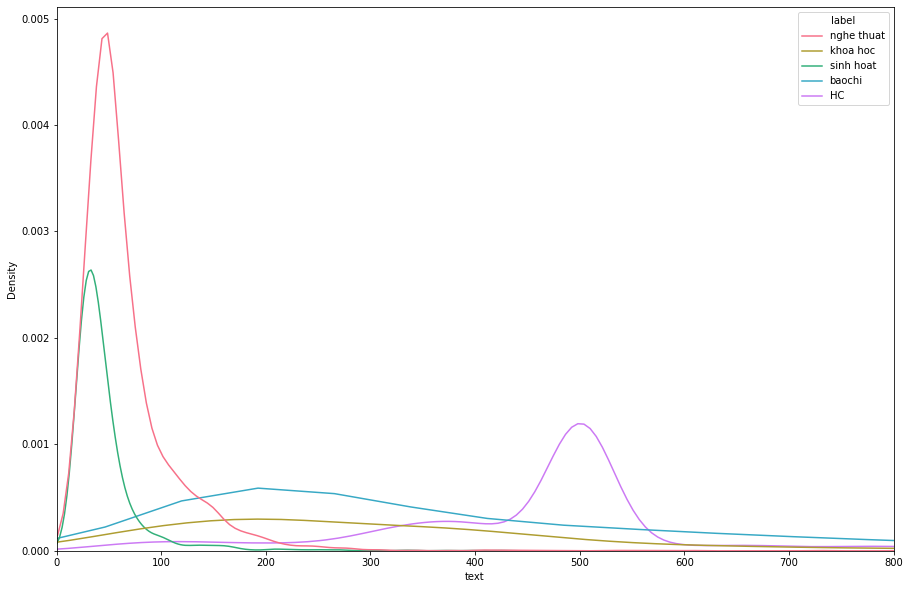

In [ ]:
sns.kdeplot(train_df['text'].apply(lambda x: len(x.split(' '))), hue = train_df['label'], palette= 'husl')
plt.xlim([0, 800])
plt.show()

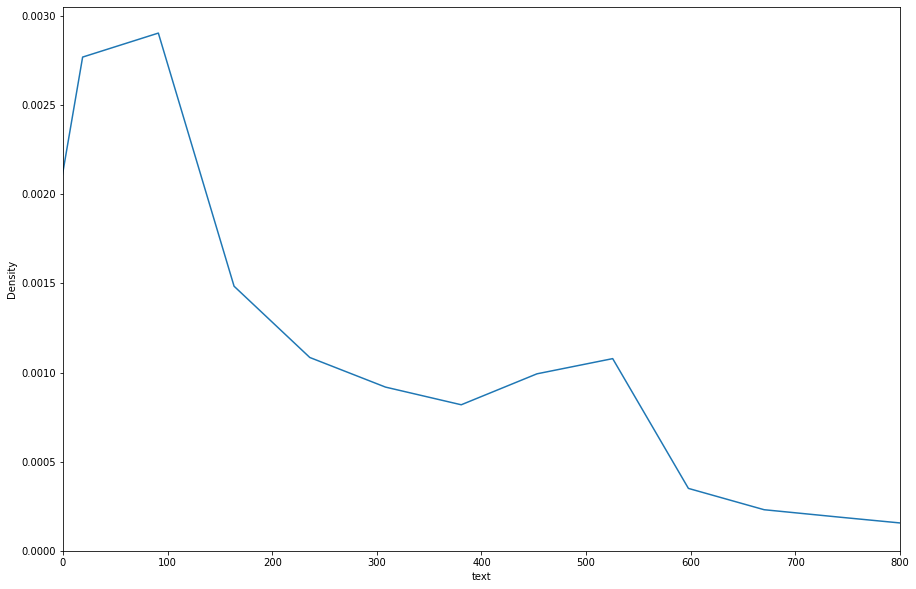

In [ ]:
sns.kdeplot(train_df['text'].apply(lambda x: len(x.split(' '))), palette= 'husl')
plt.xlim([0, 800])
plt.show()

# Hyperparameters

In [ ]:
# setup dataset & tokenizer
num_labels = 5 
max_seq_len = 100
overwrite_output_dir = True

# Training 
epochs = 3
train_batch_size = 16
val_batch_size = 16
lr = 1e-5
logging_steps = 10

step_per_epoch = int(len(train_df) / train_batch_size)
warmup_steps = int(step_per_epoch * 2/3)    #takes 2/3 first epoch for warming up

weight_decay = 0.28
gradient_accumulation_steps = 3
eval_steps = 50
output_dir = './results/'   
logging_dir = './logs/'     
# PATH = "drive/MyDrive/BERT/dataset/baochi - sinhhoat/final_modelv2"
PATH = "drive/MyDrive/BERT/model/text-mining/final_modelv3"


# Load Model + tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels= num_labels)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/vinai/phobert-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a596f267f08b7158c7ab6300b1bf98eb6e1b05e6bcb0d7c18a8070364ee3011b.bbe27b2cac909b2279c83792c2d2b6f159f0a95f5d1c1eb66451da1c89a53609
Model config RobertaConfig {
  "_name_or_path": "vinai/phobert-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "Ph

# Create custom Dataset + Padding

In [ ]:
def create_dataset(df):
    df['text'] = df['text'].astype(str)
    df['label'] = df['label'].replace(['bao chi','sinh hoat','nghe thuat', 'khoa hoc', 'HC'],[0,1,2,3,4])
    dataset = {'text': df['text'], 'label': df['label']}
    dataset = Dataset.from_dict(dataset)
    return dataset

train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)
test_dataset = create_dataset(test_df)

print(train_dataset, val_dataset, test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 18479
}) Dataset({
    features: ['text', 'label'],
    num_rows: 4620
}) Dataset({
    features: ['text', 'label'],
    num_rows: 12439
})


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length = max_seq_len)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

  0%|          | 0/19 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [ ]:
small_train_dataset = train_dataset.select(range(100)) 
small_val_dataset = train_dataset.select(range(100, 200)) 

# Metrics

In [ ]:
from datasets import list_metrics
metrics_list = list_metrics()
metrics_list

['accuracy',
 'bertscore',
 'bleu',
 'bleurt',
 'cer',
 'chrf',
 'code_eval',
 'comet',
 'competition_math',
 'coval',
 'cuad',
 'f1',
 'gleu',
 'glue',
 'google_bleu',
 'indic_glue',
 'matthews_correlation',
 'meteor',
 'pearsonr',
 'precision',
 'recall',
 'rouge',
 'sacrebleu',
 'sari',
 'seqeval',
 'spearmanr',
 'squad',
 'squad_v2',
 'super_glue',
 'ter',
 'wer',
 'wiki_split',
 'xnli']

In [ ]:
metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average = 'weighted')

Downloading:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

# Modeling

## Train

In [ ]:
%env WANDB_WATCH=all

env: WANDB_WATCH=all


In [ ]:
training_args = TrainingArguments(
    output_dir=                     output_dir,          
    num_train_epochs=               epochs,
    per_device_train_batch_size=    train_batch_size, 
    per_device_eval_batch_size=     val_batch_size,  
    warmup_steps=                   warmup_steps,               
    weight_decay=                   weight_decay,              
    overwrite_output_dir =          overwrite_output_dir,
    logging_dir=                    logging_dir,  
    evaluation_strategy=            "steps",
    eval_steps=                     eval_steps,

    report_to=                      'wandb',
    run_name=                       'text_mining bert (new datasetv2)',
    logging_steps =                 logging_steps,                    
    save_steps=                     step_per_epoch,
    gradient_accumulation_steps=    gradient_accumulation_steps 


)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics
)

PyTorch: setting up devices


In [ ]:
trainer.train()


The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 18479
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 48
  Gradient Accumulation steps = 3
  Total optimization steps = 1155
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,F1
50,1.454200,1.411457,0.436533
100,1.061800,0.960080,0.765642
150,0.516600,0.421318,0.924000
200,0.263000,0.200327,0.960478
250,0.175400,0.149445,0.963676
300,0.149000,0.105318,0.978664
350,0.106500,0.082644,0.981847
400,0.092800,0.069150,0.985490
450,0.087400,0.081116,0.978874
500,0.060100,0.060820,0.985049


The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 4620
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 4620
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 4620
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 4620
  Batch size = 16
The following columns in the evaluation set  don't have a corresponding argument in `Roberta

TrainOutput(global_step=1155, training_loss=0.2270676814084187, metrics={'train_runtime': 3451.3671, 'train_samples_per_second': 16.062, 'train_steps_per_second': 0.335, 'total_flos': 2848921965581400.0, 'train_loss': 0.2270676814084187, 'epoch': 3.0})

## Evaluation

In [ ]:
trainer.evaluate()
wandb.finish()

The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 4620
  Batch size = 16


eval/f1,▁▅▇█████████████████████
eval/loss,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,██▆▆▁▇▇██▁▇█▆█▇▇▇▆▆▇▆▆▂▇
eval/samples_per_second,▁▁▃▃█▂▂▁▁█▂▁▃▁▂▂▂▃▃▂▃▃▇▂
eval/steps_per_second,▁▁▃▃█▂▂▁▁█▂▁▃▁▂▂▂▃▃▂▃▃▇▂
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███▇▇▆▅▅▄▄▃▃▂▂▁
train/loss,██▇▆▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁


## Save model

In [ ]:
trainer.model.save_pretrained(PATH)

Configuration saved in drive/MyDrive/BERT/model/text-mining/final_modelv3/config.json
Model weights saved in drive/MyDrive/BERT/model/text-mining/final_modelv3/pytorch_model.bin


## Final test

In [ ]:
from sklearn.metrics import classification_report
# PATH_TO_MODEL = "drive/MyDrive/BERT/model/text-mining/final_model"
PATH_TO_MODEL = PATH 
try:
    model_load = AutoModelForSequenceClassification.from_pretrained(PATH_TO_MODEL)
except:
    print("Path to model ??")

inf_batch_size = 64
test_args = TrainingArguments(
    output_dir = "tmp_trainer",
    do_train = False,
    do_predict = True,
    per_device_eval_batch_size = inf_batch_size    
)

trainer = Trainer(
    model=model_load, 
    args = test_args,
)

preds = trainer.predict(test_dataset)

loading configuration file drive/MyDrive/BERT/model/text-mining/final_modelv3/config.json
Model config RobertaConfig {
  "_name_or_path": "drive/MyDrive/BERT/model/text-mining/final_modelv3",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 258,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_l

In [ ]:
from sklearn.metrics import log_loss
y_preds = np.argmax(np.array(preds[0]), axis = 1)
y_probs = softmax(np.array(preds[0]), axis = 1)

a = np.array(test_df['label'])
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1

# y_probs
print("test loss:", log_loss(b, y_probs))

test loss: 0.038628007884607934


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3500
           1       1.00      0.98      0.99      1384
           2       0.99      1.00      0.99      3675
           3       0.99      0.97      0.98      1707
           4       0.99      0.99      0.99      2173

    accuracy                           0.99     12439
   macro avg       0.99      0.99      0.99     12439
weighted avg       0.99      0.99      0.99     12439



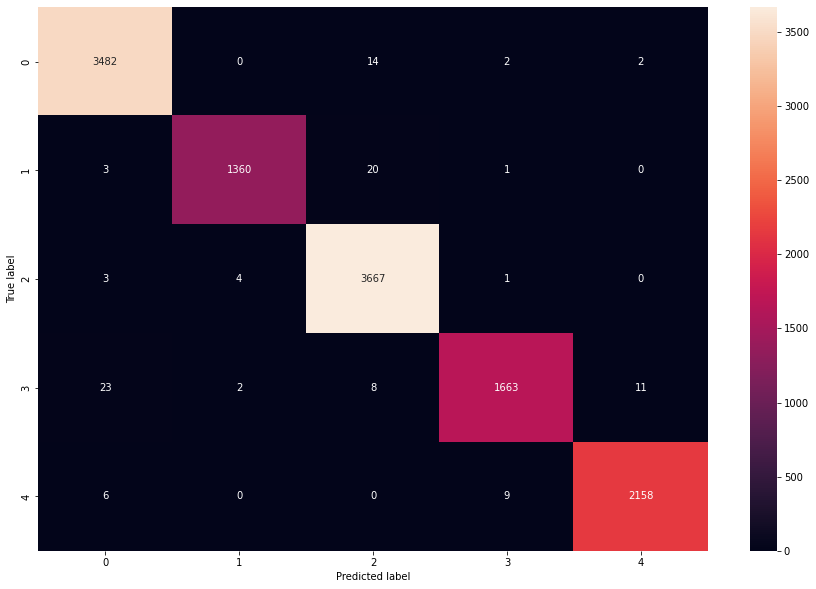

In [ ]:
print(classification_report(test_df['label'], y_preds))
sns.heatmap(confusion_matrix(test_df['label'], y_preds), annot = True, fmt='g')
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Inference

## Load model

In [ ]:
model_load = AutoModelForSequenceClassification.from_pretrained(PATH)

## Trainer for model

In [ ]:
# arguments for Trainer
inf_batch_size = 64

test_args = TrainingArguments(
    output_dir = "tmp_trainer",
    do_train = False,
    do_predict = True,
    per_device_eval_batch_size = inf_batch_size    
)

trainer = Trainer(
    model=model_load, 
    args = test_args                       
)

## Predict

In [ ]:
def preprocess(txt):
    def clean_html(raw_html):
        CLEANR = re.compile('<.*?>')    
        cleantext = re.sub(CLEANR, '', raw_html)
        return cleantext

    def remove_special_chars(txt):
        regex = r"[^,.!\"\'(...);\w\s]"
        return re.sub(regex, '', txt)

    def normalize_unicode(txt):
        def loaddicchar():
            dic = {}
            char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
                '|')
            charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
                '|')
            for i in range(len(char1252)):
                dic[char1252[i]] = charutf8[i]
            return dic
        
        
        dicchar = loaddicchar()
        

        return re.sub(r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
                    lambda x: dicchar[x.group()], txt)

    def tokenize(txt):
        return word_tokenize(txt, format="text")

    temp = txt
    temp = clean_html(temp)
    temp = remove_special_chars(temp)
    temp = normalize_unicode(temp)
    temp = temp.strip()

    temp = tokenize(temp)
    return temp

def predict(trainer, text):
    def create_dataset_inference(text):
        df = pd.DataFrame({'text': text})
        df['text'] = df['text'].astype(str)
        df['text'] = df['text'].apply(preprocess)

        dataset = {'text': df['text']}
        dataset = Dataset.from_dict(dataset)
        return dataset

    dataset = create_dataset_inference(text)
    dataset = dataset.map(tokenize_function, batched=True)
    # predict
    preds = np.array(trainer.predict(dataset)[0])

    # convert to label
    label = np.argmax(preds, axis = 1)
    prob = np.max(softmax(preds, axis = 1), axis = 1)
    
    pred_df = pd.DataFrame({'text': text, 'label': label, 'probability': prob})
    pred_df['label'] = pred_df['label'].replace([0,1,2,3,4], ['bao chi','sinh hoat','nghe thuat', 'khoa hoc', 'hanh chinh'])
    return pred_df

text = ["Jessica à, mày đã ngủ với thầy giáo đúng không", 
        "Em ơi lâu đài tình ái đó , chắc không có trên trần gian", 
        "Protein là 1 hợp chất hữu cơ rất tốt cho sức khoẻ",
        "Nhằm tăng cường miễn dịch phòng COVID-19 cho những người đã được tiêm chủng đủ liều cơ bản, Ban Chỉ đạo phòng, chống dịch COVID-19 Thành phố xây dựng Kế hoạch tổ chức tiêm vắc xin phòng COVID-19 liều bổ sung và nhắc lại tại Thành phố Hồ Chí Minh, cụ thể như sau",
        "Mới đây, ca sĩ Đàm Vĩnh Hưng đã bất ngờ chia sẻ những hình ảnh khá “mát mẻ” của mình trên trang cá nhân. Trong những bức ảnh, Mr Đàm thể hiện sự thư giãn khi tắm hồ bơi ngay trên sân thượng nhà mình, đùa nghịch cùng chim bồ câu và chú cún nhỏ, đặc biệt là khoe cả hình xăm trên ngực trần.",
        "Mày đang làm cái gì vậy, mày đã giết chết tao rồi đó, 1 cái chết thật tang thương cũng như cái cách mày làm với gia đình này. Nó ngẩng đầu lên trời, nhìn xa xăm vô định rồi bất giác gieo mình xuống dòng sông, ",
        "Canxi là dưỡng chất thiết yếu cho cơ thể, giúp cho hệ cơ xương chắc khoẻ",
        "Về việc xác định giao một phần hàng hóa nhập khẩu để thuê gia công lại trong nội địa Căn cứ khoản 1 Điều 59 Luật Hải quan quy định trách nhiệm của cơ quan hải quan trong kiểm tra",
        "Nó ngẩng đầu lên trời, nhìn xa xăm vô định rồi bất giác gieo mình xuống dòng sông nhưng không chết",
        "Hôm thi xong tôi bảo, đỗ đâu chưa biết, hai bố con phải ra bờ hồ"
        ]

pd.set_option('display.max_colwidth', None)
predict(trainer, text)



  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 10
  Batch size = 64


,text,label,probability
0,"Jessica à, mày đã ngủ với thầy giáo đúng không",sinh hoat,0.996795
1,"Em ơi lâu đài tình ái đó , chắc không có trên trần gian",nghe thuat,0.997548
2,Protein là 1 hợp chất hữu cơ rất tốt cho sức khoẻ,khoa hoc,0.996426
3,"Nhằm tăng cường miễn dịch phòng COVID-19 cho những người đã được tiêm chủng đủ liều cơ bản, Ban Chỉ đạo phòng, chống dịch COVID-19 Thành phố xây dựng Kế hoạch tổ chức tiêm vắc xin phòng COVID-19 liều bổ sung và nhắc lại tại Thành phố Hồ Chí Minh, cụ thể như sau",hanh chinh,0.997967
4,"Mới đây, ca sĩ Đàm Vĩnh Hưng đã bất ngờ chia sẻ những hình ảnh khá “mát mẻ” của mình trên trang cá nhân. Trong những bức ảnh, Mr Đàm thể hiện sự thư giãn khi tắm hồ bơi ngay trên sân thượng nhà mình, đùa nghịch cùng chim bồ câu và chú cún nhỏ, đặc biệt là khoe cả hình xăm trên ngực trần.",bao chi,0.993387
5,"Mày đang làm cái gì vậy, mày đã giết chết tao rồi đó, 1 cái chết thật tang thương cũng như cái cách mày làm với gia đình này. Nó ngẩng đầu lên trời, nhìn xa xăm vô định rồi bất giác gieo mình xuống dòng sông,",sinh hoat,0.962555
6,"Canxi là dưỡng chất thiết yếu cho cơ thể, giúp cho hệ cơ xương chắc khoẻ",khoa hoc,0.986913
7,Về việc xác định giao một phần hàng hóa nhập khẩu để thuê gia công lại trong nội địa Căn cứ khoản 1 Điều 59 Luật Hải quan quy định trách nhiệm của cơ quan hải quan trong kiểm tra,hanh chinh,0.997208
8,"Nó ngẩng đầu lên trời, nhìn xa xăm vô định rồi bất giác gieo mình xuống dòng sông nhưng không chết",nghe thuat,0.998413
9,"Hôm thi xong tôi bảo, đỗ đâu chưa biết, hai bố con phải ra bờ hồ",nghe thuat,0.998460


In [ ]:
def predict(trainer, text):
    def create_dataset_inference(text):
        df = pd.DataFrame({'text': text})
        df['text'] = df['text'].astype(str)

        dataset = {'text': df['text']}
        dataset = Dataset.from_dict(dataset)
        return dataset

    dataset = create_dataset_inference(text)
    print("padding...")
    dataset = dataset.map(tokenize_function, batched=True)
    # predict
    print("predicting...")
    preds = np.array(trainer.predict(dataset)[0])

    # convert to label
    label = np.argmax(preds, axis = 1)
    prob = np.max(softmax(preds, axis = 1), axis = 1)
    
    pred_df = pd.DataFrame({'text': text, 'label': label, 'probability': prob})
    pred_df['label'] = pred_df['label'].replace([0,1,2,3,4], ['bao chi','sinh hoat','nghe thuat', 'khoa hoc', 'hanh chinh'])
    return pred_df

In [ ]:
# csv_PATH = './drive/MyDrive/BERT/model/text-mining/final_model/final_subscene_srt_preprocessed.csv'
csv_PATH = 'PCNNHC4.csv'
# csv_PATH = 'drive/MyDrive/BERT/dataset/final_baochi_txt.csv'

temp = pd.read_csv(csv_PATH)
# temp = temp.iloc[:30000]
temp

,Text,Type
0,"định chức_năng , nhiệm_vụ , quyền_hạn và cơ_cầ...",HC
1,Trách_nhiệm và quan_hệ của Bảo_hiểm_xã_hội Việ...,HC
2,"Tổ_chức thực_hiện công_tác thông_tin , tuyên_t...",HC
3,Tổ_chức ký hợp_đồng với các tô chức làm đại_lý...,HC
4,"Tổ_chức nghiên_cứu , ứng_dụng khoa_học ; ứng_d...",HC
...,...,...
2121,"Chi khen_thưởng , phúc_lợi cho cán_bộ , nhân_v...",HC
2122,Giảm 80 phí thi_hành án đối_với người được thi...,HC
2123,"Trong quá_trình thực_hiện nếu có vướng_mắc , đ...",HC
2124,Đơn đề_nghị được miễn hoặc giảm phí thi_hành á...,HC


In [ ]:
temp = predict(trainer, temp['Text'])
temp

padding...


  0%|          | 0/3 [00:00<?, ?ba/s]

The following columns in the test set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text.
***** Running Prediction *****
  Num examples = 2126
  Batch size = 64


predicting...


,text,label,probability
0,"định chức_năng , nhiệm_vụ , quyền_hạn và cơ_cầ...",hanh chinh,0.997936
1,Trách_nhiệm và quan_hệ của Bảo_hiểm_xã_hội Việ...,hanh chinh,0.998075
2,"Tổ_chức thực_hiện công_tác thông_tin , tuyên_t...",hanh chinh,0.998033
3,Tổ_chức ký hợp_đồng với các tô chức làm đại_lý...,hanh chinh,0.998083
4,"Tổ_chức nghiên_cứu , ứng_dụng khoa_học ; ứng_d...",hanh chinh,0.998059
...,...,...,...
2121,"Chi khen_thưởng , phúc_lợi cho cán_bộ , nhân_v...",hanh chinh,0.997917
2122,Giảm 80 phí thi_hành án đối_với người được thi...,hanh chinh,0.997985
2123,"Trong quá_trình thực_hiện nếu có vướng_mắc , đ...",hanh chinh,0.998062
2124,Đơn đề_nghị được miễn hoặc giảm phí thi_hành á...,hanh chinh,0.998059


In [ ]:
temp['label'].value_counts()

hanh chinh    2081
khoa hoc        32
bao chi          9
nghe thuat       3
sinh hoat        1
Name: label, dtype: int64